# Bloom Filter and Performance Testing


## Imports
Import necessary libraries and modules.


In [37]:
import math
import hashlib
import tracemalloc
import matplotlib.pyplot as plt
import random
import timeit

## Bloomfilter
Define the `BloomFilter` class with methods for initializing, inserting, and searching elements.


In [38]:
class BloomFilter:
    """A Bloom Filter to check if an item might be in a set."""

    def __init__(self, dataset, P=0.01):
        """
        Initialize the Bloom Filter with items.

        Parameters:
            dataset (list): Items to add to the Bloom Filter.
            P (float, optional): Desired false positive rate. Default is 0.01.

        This method sets up the Bloom Filter with the provided list of items,
        calculates the necessary size of the bit array and the number of hash functions,
        and starts with an empty bit array to which each item from the dataset is added.
        """
        self.word_count = len(dataset)
        self.P = P
        self._calculate_parameters()
        self.bit_array = [0] * self.m  # Create an empty bit array
        for element in dataset:
            self.insert_into_bit_array(element)  # Add each item to the bit array

    def _calculate_parameters(self):
        """
        Calculate the size of bit array (m) and number of hash functions (k).

        This is based on the expected number of elements in the dataset (word_count) and
        the desired probability of false positives (P).
        """
        m_float = - (self.word_count * math.log(self.P)) / (math.log(2) ** 2)
        k_float = (m_float / self.word_count) * math.log(2)
        # Round up to ensure the bit array is large enough
        self.m = int(m_float) + 1 if m_float > int(m_float) else int(m_float)
        # Round up to ensure we have enough hash functions
        self.k = int(k_float) + 1 if k_float > int(k_float) else int(k_float)

    def insert_into_bit_array(self, element):
        """
        Add an item to the Bloom Filter by setting bits at k positions determined by hashing the item k times.

        Parameters:
            element (str): The item to add.
        """
        for i in range(self.k):
            # Create a unique hash for each combination of element and i
            digest = hashlib.sha1((str(element) + str(i)).encode('utf-8')).hexdigest()
            index = int(digest, 16) % self.m  # Convert hash to an index within the bit array
            self.bit_array[index] = 1  # Set the bit at the calculated index

    def search_bit_array(self, element):
        """
        Check if an item might be in the Bloom Filter by verifying that all k bits corresponding
        to the k hashes of the item are set.

        Parameters:
            element (str): The item to check.

        Returns:
            bool: True if the item might be in the set, False if it is definitely not.
        """
        for i in range(self.k):
            # Create a unique hash for each combination of element and i
            digest = hashlib.sha1((str(element) + str(i)).encode('utf-8')).hexdigest()
            index = int(digest, 16) % self.m  # Convert hash to an index within the bit array
            if not self.bit_array[index]:  # If any bit is not set, the element is definitely not in the set
                return False
        return True  # All bits are set, so the element might be in the set

    def __repr__(self):
        return f"Bloom_Filter(size={len(self.bit_array)}, P={self.P}, dataset_size={len(self.dataset)})"

    def __str__(self):
        return f"Bloom Filter with {self.word_count} items and false positive rate {self.P}"


def create_BF_from_dataset(dataset, P=0.01):
    return BloomFilter(dataset, P)

## Testing

We will now insert different types of data and datasets to inspect whether our code works correctly. After we will also perform some search tests.

### Importing datasets to create bloomfilters

First, we import different types of data.

In [39]:
# 1. URLs
urls = [
    "http://example.com",
    "https://example.org",
    "http://test.com",
    "https://mywebsite.net",
    "http://anotherexample.com",
]
url_bloom = BloomFilter(urls, P=0.1)  # note that we change the P value to performance false negative testing
print(url_bloom)

# 2. emails
emails = [
    "example1@example.com",
    "user2@test.org",
    "contact@mydomain.net",
    "admin@website.com",
    "info@anotherexample.com",
]
email_bloom = BloomFilter(emails)
print(email_bloom)

# 3. IP addresses
ip_addresses = [
    "192.168.0.1",
    "10.0.0.2",
    "172.16.0.3",
    "8.8.8.8",
    "127.0.0.1",
]
IP_bloom = BloomFilter(ip_addresses)
print(IP_bloom)

# 4. English words
english_words = [
    "apple",
    "banana",
    "cherry",
    "date",
    "elderberry",
    "fig",
    "grape",
    "honeydew",
    "kiwi",
    "lemon",
]
# note that we change the P value to performance false negative testing)
words_bloom = BloomFilter(english_words, P=0.1)
print(words_bloom)

# 5. DNA
dna_sequences = [
    "AGCTTAGCTA",
    "CGTAGCTAGC",
    "TGCATGCACT",
    "GCTAGCTAGC",
    "TAGCTAGCTA",
]
DNA_bloom = BloomFilter(dna_sequences)
print(DNA_bloom)

# 6. Importing data with words of a short length
four_letter_words = [
    "bark", "clap", "dear", "echo", "fist", "gift", "hint", "jazz", "kite", "lamp",
    "mint", "nest", "pace", "quip", "rain", "snow", "toad", "urge", "vase", "warp",
    "arch", "bank", "dove", "flip", "gold", "hail", "jump", "leaf", "muse", "note"
]
four_letter_bloom = BloomFilter(four_letter_words)
print(four_letter_bloom)

Bloom Filter with 5 items and false positive rate 0.1
Bloom Filter with 5 items and false positive rate 0.01
Bloom Filter with 5 items and false positive rate 0.01
Bloom Filter with 10 items and false positive rate 0.1
Bloom Filter with 5 items and false positive rate 0.01
Bloom Filter with 30 items and false positive rate 0.01


We noted that all the data gets loaded in correctly.

Next, we import different types of datasets.

In [40]:
# 1. Txt file with words

words_dataset = []
with open("English_words.txt", 'r') as datafile:
    words_dataset = [line.strip() for line in datafile]

# note that we change the P value to performance false negative testing
wordtxt_bloom = BloomFilter(words_dataset, P=0.1)
print(wordtxt_bloom)

# 2. Txt file with sequences

sequences_dataset = []
with open("sequences.txt", 'r') as datafile:
    sequences_dataset = [line.strip() for line in datafile]

sequences_bloom = BloomFilter(sequences_dataset)
print(sequences_bloom)

# 3. Csv file with a 1000 English words

english_words_dataset = []
with open("English_words.csv", 'r') as datafile:
    english_words_dataset = [line.strip() for line in datafile]

english_words_bloom = BloomFilter(english_words_dataset)
print(english_words_bloom)

Bloom Filter with 466550 items and false positive rate 0.1
Bloom Filter with 2000 items and false positive rate 0.01
Bloom Filter with 600 items and false positive rate 0.01


We noted that also for these larger datasets imported into the bloomfilter, the bloomfilter gets generated.

### Search in the bloomfilters

1. True positive

In [41]:
dna_sequences_test = [
    "AGCTTAGCTA",
    "CGTAGCTAGC",
    "TGCATGCACT",
    "GCTAGCTAGC"]

for word in dna_sequences_test:
    result = DNA_bloom.search_bit_array(word)
    print(f"Word '{word}' found: {result}")

Word 'AGCTTAGCTA' found: True
Word 'CGTAGCTAGC' found: True
Word 'TGCATGCACT' found: True
Word 'GCTAGCTAGC' found: True


In [42]:
sequences_test = [
    "CGTATCTTCGTGTGCTCTCCTTTAGAACTGCATCTCTAGAGTCAGAGAGG",
    "AGAGCATTGTATCCGACCGAACTCCTGTAGTGACAAAACCGTCCTCAATG",
    "TCGACCGAACTCCCTGCCTCTCATCGCGGATCACGTCCGCCGAGATAATA"]

for word in sequences_test:
    result = sequences_bloom.search_bit_array(word)
    print(f"Word '{word}' found: {result}")

Word 'CGTATCTTCGTGTGCTCTCCTTTAGAACTGCATCTCTAGAGTCAGAGAGG' found: True
Word 'AGAGCATTGTATCCGACCGAACTCCTGTAGTGACAAAACCGTCCTCAATG' found: True
Word 'TCGACCGAACTCCCTGCCTCTCATCGCGGATCACGTCCGCCGAGATAATA' found: True


We noted that all the words were correctly found.

2. False positive

In [43]:
url_bloom_test = [
    "https://www.bbc.com/",
    "https://www.twitter.com/",
    "https://www.youtube.com/",
    "https://www.amazon.com/",
    "https://www.google.com/",
    "https://www.khanacademy.org/",
    "https://www.theverge.com/",
    "https://www.webmd.com/",
    "https://www.booking.com/",
    "https://www.imdb.com/"
]

for word in url_bloom_test:
    result = url_bloom.search_bit_array(word)
    print(f"Word '{word}' found: {result}")

Word 'https://www.bbc.com/' found: False
Word 'https://www.twitter.com/' found: False
Word 'https://www.youtube.com/' found: False
Word 'https://www.amazon.com/' found: False
Word 'https://www.google.com/' found: False
Word 'https://www.khanacademy.org/' found: False
Word 'https://www.theverge.com/' found: False
Word 'https://www.webmd.com/' found: False
Word 'https://www.booking.com/' found: True
Word 'https://www.imdb.com/' found: False


We noted that one title was returned as found even though it wasn't in the original list.

In [44]:
wordtxt_bloom_test = [
    "bark", "test", "four", "unbelivehrdafkd", "fist", "gift", "hint", "jazz", "kite", "lamp",
    "mint", "nest", "pace", "quip", "rain", "snow", "toad", "urge", "vase", "warp",
    "arch", "bank", "dove", "flip", "gold", "hail", "jump", "leaf", "muse", "note"
]

for word in wordtxt_bloom_test:
    result = wordtxt_bloom.search_bit_array(word)
    print(f"Word '{word}' found: {result}")

Word 'bark' found: True
Word 'test' found: True
Word 'four' found: False
Word 'unbelivehrdafkd' found: False
Word 'fist' found: True
Word 'gift' found: True
Word 'hint' found: True
Word 'jazz' found: True
Word 'kite' found: True
Word 'lamp' found: False
Word 'mint' found: True
Word 'nest' found: True
Word 'pace' found: False
Word 'quip' found: True
Word 'rain' found: True
Word 'snow' found: False
Word 'toad' found: True
Word 'urge' found: True
Word 'vase' found: True
Word 'warp' found: False
Word 'arch' found: True
Word 'bank' found: True
Word 'dove' found: False
Word 'flip' found: False
Word 'gold' found: False
Word 'hail' found: True
Word 'jump' found: False
Word 'leaf' found: False
Word 'muse' found: False
Word 'note' found: True


3. True negative

In [45]:
four_letter_words_test = [
    "bark", "test", "four", "unbelivehrdafkd", "fist", "gift", "hint", "jazz", "kite", "lamp",
    "mint", "nest", "pace", "quip", "rain", "snow", "toad", "urge", "vase", "warp",
    "arch", "bank", "dove", "flip", "gold", "hail", "jump", "leaf", "muse", "note"
]

for word in four_letter_words_test:
    result = four_letter_bloom.search_bit_array(word)
    print(f"Word '{word}' found: {result}")

Word 'bark' found: True
Word 'test' found: False
Word 'four' found: False
Word 'unbelivehrdafkd' found: False
Word 'fist' found: True
Word 'gift' found: True
Word 'hint' found: True
Word 'jazz' found: True
Word 'kite' found: True
Word 'lamp' found: True
Word 'mint' found: True
Word 'nest' found: True
Word 'pace' found: True
Word 'quip' found: True
Word 'rain' found: True
Word 'snow' found: True
Word 'toad' found: True
Word 'urge' found: True
Word 'vase' found: True
Word 'warp' found: True
Word 'arch' found: True
Word 'bank' found: True
Word 'dove' found: True
Word 'flip' found: True
Word 'gold' found: True
Word 'hail' found: True
Word 'jump' found: True
Word 'leaf' found: True
Word 'muse' found: True
Word 'note' found: True


We noted that the words that we inserted (test, four and unbelivehrdafkd) were not found as expected.

In [46]:
for word in ["agony", "bread", "dad"]:
    result = english_words_bloom.search_bit_array(word)
    print(f"Word '{word}' found: {result}")

Word 'agony' found: False
Word 'bread' found: False
Word 'dad' found: False


As expected, we did not find any false negatives in our testing.

## Performance
Define the `BloomFilterPerformanceTest` class with methods for setting up tests, creating and searching the Bloom Filter, generating random words, and running tests.


In [47]:
class BloomFilterPerformanceTest:
    """A class to test the performance of the Bloom Filter."""

    def __init__(self, dataset, dataset_sizes, num_runs=10, num_queries=1000):
        """
        Set up the performance test.

        Parameters:
            dataset (list): The list of items to test with.
            dataset_sizes (list): List of sizes of datasets to test with.
            num_runs (int, optional): How many times to run the test for each size. Default is 10.
            num_queries (int, optional): How many queries to make for false positives. Default is 1000.

        This method initializes the performance test with the dataset and different sizes to test,
        sets up how many times to run each test and how many queries to use for checking false positives,
        and prepares a results dictionary to store test outcomes.
        """
        self.dataset = dataset
        self.dataset_sizes = dataset_sizes
        self.num_runs = num_runs
        self.num_queries = num_queries
        self.results = {size: {'creation_times': [], 'insertion_times': [], 'average_search_times': [],
                               'memory_usages': [], 'false_positive_rates': []} for size in dataset_sizes}

    def search_bf(self, bf, dataset):
        """
        Check all items in the dataset against the Bloom Filter.

        Parameters:
            bf (BloomFilter): The Bloom Filter to search with.
            dataset (list): The list of items to check.
        """
        for element in dataset:
            bf.search_bit_array(element)  # Search each element in the Bloom Filter

    def generate_random_words_not_in_dataset(self, dataset, num_words, length=10):
        """
        Create a list of random words not in the dataset.

        Parameters:
            dataset (list): The original dataset to ensure new words are not in it.
            num_words (int): Number of random words to generate.
            length (int, optional): Length of each random word. Default is 10.

        Returns:
            list: A list of random words not in the dataset.

        This method generates random words not in the given dataset. It is useful for testing, especially for
        evaluating the Bloom Filter's false positive rate.
        """
        dataset_set = set(dataset)
        random_words = set()
        characters = 'abcdefghijklmnopqrstuvwxyz'

        while len(random_words) < num_words:
            word = ''.join(random.choices(characters, k=length))  # Generate a random word
            if word not in dataset_set:  # Ensure the word is not in the dataset
                random_words.add(word)

        return list(random_words)

    def run_tests(self):
        """
        Run the performance tests on the Bloom Filter.

        Measure creation time, insertion time, search time, memory usage, and false positive rate.
        """
        for size in self.dataset_sizes:
            sample_dataset = self.dataset[:size]  # Take a sample of the dataset of the given size
            for _ in range(self.num_runs):
                tracemalloc.start()  # Start measuring memory usage

                bf = create_BF_from_dataset(sample_dataset)  # Create the Bloom Filter
                creation_time = timeit.timeit(lambda: create_BF_from_dataset(
                    sample_dataset), number=1)  # Measure creation time

                current, peak = tracemalloc.get_traced_memory()  # Measure memory usage
                tracemalloc.stop()

                memory_usage = current / 1_000_000  # Convert memory usage to megabytes (MB)
                self.results[size]['creation_times'].append(creation_time)
                self.results[size]['memory_usages'].append(memory_usage)

                insertion_time = timeit.timeit(lambda: [bf.insert_into_bit_array(item)
                                               for item in sample_dataset], number=1)
                self.results[size]['insertion_times'].append(insertion_time)

                search_time = timeit.timeit(lambda: self.search_bf(bf, sample_dataset), number=1)  # Measure search time
                average_search_time = search_time / len(sample_dataset)  # Calculate average search time per item
                self.results[size]['average_search_times'].append(average_search_time)

                false_positives = 0  # Check for false positives
                random_words = self.generate_random_words_not_in_dataset(sample_dataset, self.num_queries)
                for test_element in random_words:
                    if bf.search_bit_array(test_element):
                        false_positives += 1

                false_positive_rate = false_positives / self.num_queries  # Calculate false positive rate
                self.results[size]['false_positive_rates'].append(false_positive_rate)

                del bf  # Delete the Bloom Filter to free up memory

    def print_results(self):
        """
        Print the test results.

        Show creation time, insertion time, memory usage, average search time, and false positive rate.
        """
        for size in self.dataset_sizes:
            print(f"Results for dataset size {size}:")
            creation_time = sum(self.results[size]['creation_times']) / len(self.results[size]['creation_times'])
            insertion_time = sum(self.results[size]['insertion_times']) / len(self.results[size]['insertion_times'])
            memory_usage = sum(self.results[size]['memory_usages']) / len(self.results[size]['memory_usages'])
            average_search_time = sum(self.results[size]['average_search_times']) / \
                len(self.results[size]['average_search_times'])
            false_positive_rate = sum(self.results[size]['false_positive_rates']) / \
                len(self.results[size]['false_positive_rates'])
            print(f"  Average Creation Time: {creation_time:.6f} seconds")
            print(f"  Average Insertion Time: {insertion_time:.6f} seconds")
            print(f"  Average Memory Usage: {memory_usage:.6f} MB")
            print(f"  Average Search Time: {average_search_time:.6f} seconds")
            print(f"  False Positive Rate: {false_positive_rate * 100:.2f}%")
            print()

    def plot_results(self):
        """
        Plot the test results.

        Create plots for creation time, insertion time, memory usage, average search time, and false positive rate.
        """
        sizes = self.dataset_sizes  # Dataset sizes used for the tests

        avg_creation_times = [sum(self.results[size]['creation_times']) /
                              len(self.results[size]['creation_times']) for size in sizes]
        avg_insertion_times = [sum(self.results[size]['insertion_times']) /
                               len(self.results[size]['insertion_times']) for size in sizes]
        avg_memory_usages = [sum(self.results[size]['memory_usages']) /
                             len(self.results[size]['memory_usages']) for size in sizes]
        avg_search_times = [sum(self.results[size]['average_search_times']) /
                            len(self.results[size]['average_search_times']) for size in sizes]
        avg_false_positive_rates = [sum(self.results[size]['false_positive_rates']) /
                                    len(self.results[size]['false_positive_rates']) for size in sizes]

        plt.figure(figsize=(14, 10))

        plt.subplot(2, 3, 1)
        plt.plot(sizes, avg_creation_times, marker='o', linestyle='-', color='b')
        plt.xlabel('Dataset Size')
        plt.ylabel('Creation Time (s)')
        plt.title('Bloom Filter Creation Time')

        plt.subplot(2, 3, 2)
        plt.plot(sizes, avg_insertion_times, marker='o', linestyle='-', color='c')
        plt.xlabel('Dataset Size')
        plt.ylabel('Insertion Time (s)')
        plt.title('Bloom Filter Insertion Time')

        plt.subplot(2, 3, 3)
        plt.plot(sizes, avg_memory_usages, marker='o', linestyle='-', color='r')
        plt.xlabel('Dataset Size')
        plt.ylabel('Memory Usage (MB)')
        plt.title('Memory Usage')

        plt.subplot(2, 3, 4)
        plt.plot(sizes, avg_search_times, marker='o', linestyle='-', color='g')
        plt.xlabel('Dataset Size')
        plt.ylabel('Average Search Time (s)')
        plt.title('Average Search Time')

        plt.subplot(2, 3, 5)
        plt.plot(sizes, avg_false_positive_rates, marker='o', linestyle='-', color='m')
        plt.xlabel('Dataset Size')
        plt.ylabel('False Positive Rate')
        plt.title('False Positive Rate')

        plt.tight_layout()
        plt.show()

## Load the Dataset
Load the dataset  <DNA_sequences.txt> and execute the performance tests.


In [50]:
# Define the function to load the dataset and load the dataset directly within the notebook
def load_dataset(file_path):
    dataset = []
    try:
        with open(file_path, 'r', encoding='latin1') as datafile:
            dataset = [line.strip() for line in datafile.readlines() if line.strip()]
            if not dataset:
                raise ValueError("The dataset is empty.")
            print(f'Successfully read {len(dataset)} lines from the file.')
    except FileNotFoundError:
        print(f'Error: File not found: {file_path}')
        sys.exit(1)
    except Exception as e:
        print(f'Error: {e}')
        sys.exit(1)
    return dataset


# Load the dataset directly within the notebook
sequences_dataset = load_dataset("DNA_sequences.txt")

Successfully read 2000 lines from the file.


## Run the Performance test & Plot results 

Results for dataset size 20:
  Average Creation Time: 0.001766 seconds
  Average Insertion Time: 0.000412 seconds
  Average Memory Usage: 0.001825 MB
  Average Search Time: 0.000019 seconds
  False Positive Rate: 0.78%

Results for dataset size 100:
  Average Creation Time: 0.010627 seconds
  Average Insertion Time: 0.002448 seconds
  Average Memory Usage: 0.007808 MB
  Average Search Time: 0.000020 seconds
  False Positive Rate: 1.14%

Results for dataset size 200:
  Average Creation Time: 0.015171 seconds
  Average Insertion Time: 0.003516 seconds
  Average Memory Usage: 0.015552 MB
  Average Search Time: 0.000019 seconds
  False Positive Rate: 1.13%

Results for dataset size 500:
  Average Creation Time: 0.039777 seconds
  Average Insertion Time: 0.008060 seconds
  Average Memory Usage: 0.038580 MB
  Average Search Time: 0.000019 seconds
  False Positive Rate: 1.06%

Results for dataset size 1000:
  Average Creation Time: 0.068695 seconds
  Average Insertion Time: 0.013635 seconds
 

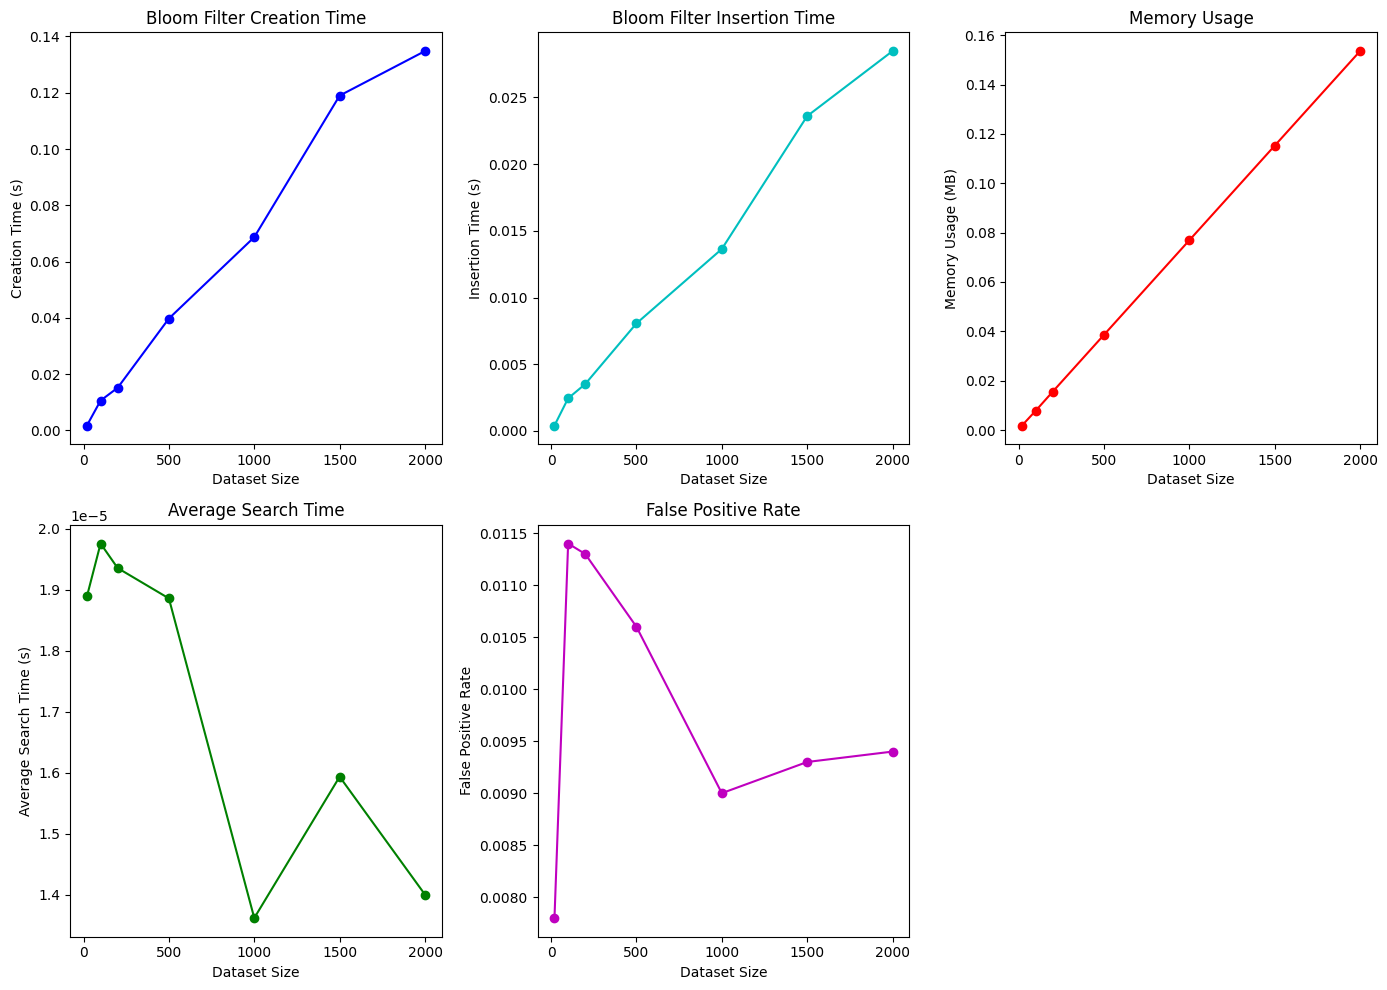

In [51]:
# Define dataset sizes as percentages of the actual dataset size, testing the Bloom Filter with increasing data size.
actual_dataset_size = len(sequences_dataset)
dataset_percentages = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0]
dataset_sizes = [int(actual_dataset_size * percentage) for percentage in dataset_percentages]

# Create a performance test instance
performance_test = BloomFilterPerformanceTest(sequences_dataset, dataset_sizes)

# Run the performance tests
performance_test.run_tests()

# Print the results
performance_test.print_results()

# Plot the results
performance_test.plot_results()